In [33]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from theano.compile.ops import as_op
import theano.tensor as tt
from scipy.linalg import block_diag
from scipy import stats
from scipy.stats import binned_statistic

In [34]:
#checking verison of pymc3
print('Running on PyMC3 v{}'.format(pm.__version__))
#inputting data
#data_base = np.loadtxt("Lyman_alpha_result_balout_z=3.2-3.3_testing.txt")
data_z = np.loadtxt("beta_z_ratio_mcmc_990-1010_avecombine_highz_newbin_cut1075snrcut.txt")
data_all = np.loadtxt("beta_flux_990-1010_mcmcflux_avecombine_highz_newbin_cut1075snrcur.txt")
data_error = np.loadtxt("testbeta_990-1010_error.txt")
covariance = np.loadtxt("testbeta_990-1010_co.txt")

data_z = data_z[:,0]
print (data_z)
i = range(0, len(data_all))
data_indi_flux = np.split(data_all[i,1], len(data_z))
data_indi_wave = np.split(data_all[i,0], len(data_z))
data_error_split = np.split(data_error, len(data_z))
covariance_split = np.split(covariance, len(data_z))

print (covariance_split)


data_indi_flux = data_indi_flux[3:]
data_indi_wave = data_indi_wave[3:]
data_error_split = data_error_split[3:]
data_z = data_z[3:]
#using schaye metal correction
data_indi_tau = [0.146,0.187,0.229,0.280,0.36]
data_redshift_base = [2.0,2.2,2.4,2.6,2.8]
data_error_base = [0.018,0.013,0.009,0.01,0.012]
data_indi_flux_final = np.append(data_indi_flux,np.array(data_indi_tau))
#data_error_final=np.append(data_error_split,np.array(data_error_base))

Running on PyMC3 v3.5
[2.59377122 2.65420221 2.7478156  2.84951906 2.95062568 3.04920323
 3.14875524 3.2480309  3.3450856  3.4461385  3.5517966  3.64821476
 3.74814819 3.84550346 3.94690707 4.08444481 4.28969931 4.49270692
 4.69101035]
[array([ 0.04400796, -0.00234963,  0.00737298, ...,  0.00048655,
        0.00182007,  0.0043421 ]), array([5.59338718e-04, 7.70494662e-05, 2.91524557e-05, ...,
       1.33828071e-05, 6.32445663e-05, 2.17034103e-04]), array([2.48227239e-04, 8.55286125e-05, 2.38888078e-05, ...,
       3.30905132e-05, 6.47295456e-05, 1.45909682e-04]), array([2.05985038e-04, 1.15058901e-04, 7.47917511e-05, ...,
       5.35537038e-05, 7.36938819e-05, 1.29471970e-04]), array([1.29713531e-04, 7.94578154e-05, 5.53742175e-05, ...,
       3.90946443e-05, 5.88974908e-05, 9.89496621e-05]), array([1.25679828e-04, 7.84636431e-05, 4.97979636e-05, ...,
       3.87236396e-05, 6.41732186e-05, 9.99475815e-05]), array([1.22954822e-04, 8.35929823e-05, 6.11111536e-05, ...,
       4.19387179e-

In [35]:
data_error_base = block_diag(np.array(data_error_base))
contrain_co1 = np.zeros((5,5))
indice = np.diag_indices(5)

contrain_co1[indice] = np.array(data_error_base)
print (contrain_co1)

[[0.018 0.    0.    0.    0.   ]
 [0.    0.013 0.    0.    0.   ]
 [0.    0.    0.009 0.    0.   ]
 [0.    0.    0.    0.01  0.   ]
 [0.    0.    0.    0.    0.012]]


In [36]:
covariance_re = []
for i in range (0,len(data_z)):
    covariance_re.append(np.reshape(covariance_split[i],(76,76)))

    
#covariance_re.append(contrain_co1)



In [37]:
# costruct the final covariance matrix
covariance_final = block_diag(*covariance_re)

print (len(np.array(covariance_final)))

1216


In [38]:
covtol1 = np.loadtxt("./jiani0126/dr14_990-1010_co_10000_0.9_testing_snr2.2_tol_1.txt")

In [39]:

covtolsplit = np.split(covtol1,19)
covtest= []
for ii in range(3,len(covtolsplit)):
    covtest.append(np.transpose(np.split(covtolsplit[ii],10000)))

final_cov = np.dot(np.vstack(covtest),np.transpose(np.vstack(covtest)))/(len(np.vstack(covtest))-1)


In [40]:
print (len(final_cov))

1216


In [41]:
#data = np.loadtxt("deltatau_0606.txt")
#tau_model = [0.232,0.277,0.332,0.356,0.395,0.438,0.502,0.552,0.680,0.964]


In [84]:
#data = np.loadtxt("deltatau_0320.txt")
#tau_model = [0.244,0.289,0.343,0.367,0.406,0.450,0.513,0.563,0.692,0.977]
#tau_model = np.loadtxt("tau_model_new_0320_metal")
data = np.loadtxt("tau_0909.txt")
tau_model = [0.269049,0.323708,0.376354,0.402698,0.457069,0.519311,0.582262,0.684700,0.851293,1.091899]

In [85]:
tau_model

[0.269049,
 0.323708,
 0.376354,
 0.402698,
 0.457069,
 0.519311,
 0.582262,
 0.6847,
 0.851293,
 1.091899]

In [86]:
x2t = np.sort(np.ravel(data[:,0]))
xinterl = binned_statistic(x2t[x2t<3.5],x2t[x2t<3.5],bins = 10-3)[0]
xinterh = binned_statistic(x2t[x2t>3.5],x2t[x2t>3.5],bins = 3)[0]
xinter = np.append(xinterl,xinterh)
tau= interp1d(xinter,tau_model,fill_value = 'extrapolate')
tau_1=tau(data[:,0])

In [87]:
def plot_MCMC_model(n,xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    
    
    mean = []

    for i in range(0,n+3):
         mean.append(summary(trace)['mean'][i])
    
     
    #x = data_indi_wave[5] / 1215.67 * (1+data_z[5]) - 1
        #converting restframe wavelength to absorption redhsift for alpha
    xalpha = np.array(data_indi_wave) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1
        
        #converting restframe wavelength to absorption redhsift for beta
    xbeta = np.array(data_indi_wave) / np.array(1026 / (1+np.array(np.split(data_z, len(data_z))))) - 1

        
               
        
        
        #wavelength for continuum model
    xi = np.linspace(data_indi_wave[5][0], data_indi_wave[5][len(data_indi_wave[5])- 1], n)
        
    result_final = interp1d(xi, np.array(mean[3:(n+3)]), kind='cubic')(data_indi_wave[5])*np.exp(-func(xalpha,mean[0],mean[1])-func(xbeta,mean[2],mean[1]))
      

       
       
    
    fig, ax = plt.subplots(8, 2, figsize=(13, 15), gridspec_kw={'wspace': 0.08, 'hspace': 0.25}, sharex=False, sharey=False)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=1.2, top=0.9)
    k = 0

    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            ax[index][jndex].plot(np.array(data_indi_wave[k]/1026*(1+data_z[k]))-1, data_indi_flux[k], label=str('{:.2f}'.format(data_z[k])) + ' data')
            ax[index][jndex].plot(np.array(data_indi_wave[k]/1026*(1+data_z[k]))-1, result_final[k], label='model')
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--',label = str(names[i]))
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--')
        # ax[index][jndex].annotate('0.25 on axes', (0.25,4530), textcoords='data', size=20)
            ax[index][jndex].legend()
            ax[index][jndex].set_xlabel('redshift')
            ax[index][jndex].set_ylabel('flux')
        #ax[index][jndex].set_xticklabels('{:.2f}'.format(np.array(data_indi_wave[i]/1215.67*(1+data_z[i]))))


            k = k + 1
    plt.savefig('')
    plt.show(fig)
 
   # plt.fill_between(xdata, mu - sig, mu + sig, color='lightgray')
    
    

    return  result_final

In [ ]:
wave = np.linspace(975,1010,70)
zalpha = wave/1215.67*4.5-1
zbeta = wave/1026*4.5-1
plt.plot(wave,np.exp(-func(zbeta,0.19,3.16)-func(zalpha,0.44,3.16)))


In [47]:
import corner

In [48]:
def corner_plot(n,trace):
    cornerplot = []
    #cornerplot.append(trace['amp'])
    cornerplot.append(trace['index'])
    cornerplot.append(trace['amp'])

    names = []
    for i in range(0,n):
        cornerplot.append(trace['conti'+str(i)])
        names.append('conti'+str(i))
    
    figure = corner.corner(np.transpose(np.vstack(np.array(cornerplot))).reshape(len(trace['amp']),2+n),labels=["Amp", "Index",*names],show_titles=True, title_kwargs={"fontsize": 12},title_fmt = '.3f', quantiles = [0.32,0.5,0.68])
    plt.savefig('Corner_plot_TEST.pdf')
    plt.show()
    
   
    
    
    return cornerplot



In [135]:
def deltabeta(xdata,dataflux,ref,data_z,bins,covtest):
    xalpha = np.array(xdata) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1
        
        #converting restframe wavelength to absorption redhsift for beta
    xbeta = np.array(xdata) / np.array(1026 / (1+np.array(np.split(data_z, len(data_z))))) - 1

        
    #x2 = np.array(xdata) / np.array(1215.67 / (1+np.array(np.split(data_zf, len(data_zf))))) - 1
   
    xalphai = np.ravel(xalpha)
    xbetai = np.ravel(xbeta)
    datarel = dataflux/dataflux[1]
    #int (np.mean(xalpha[1]),np.mean(xbeta[1]))
    fluxi = np.ravel(datarel)
    ind = np.unravel_index(np.argsort(xbetai, axis=None), xbetai.shape)
    xbetabin = stats.binned_statistic(xbetai[ind], xbetai[ind], statistic='mean',bins = bins)
    #xalphabin = stats.binned_statistic(xbetai[ind], xalphai[ind], statistic='mean',bins = bins)
    #fluxbin = stats.binned_statistic(xbetai[ind], fluxi[ind], statistic='mean',bins = bins)
    #print (fluxbin)
    deltatau = -np.log(fluxi/np.mean(fluxi[np.where((ref-0.05 < xbetai)&(xbetai< ref+0.05))]))
    #rint (np.mean(fluxi[np.where((ref-0.05 < xbetai)&(xbetai< ref+0.05))]))
   
   #deltaalpha = func(xalphai,0.432,3.25)-func((1+ref)*1026/1216-1,0.432,3.25)
    deltaalpha = np.ravel(tau(xalpha)-tau(xalpha[1]))
    deltatau_beta = deltatau- deltaalpha
  # plt.scatter(xbetai,fluxi/np.mean(fluxi[np.where((ref-0.05 < xbetai)&(xbetai< ref+0.05))]),s=1)
    plt.scatter(xbetai,deltatau_beta)
    plt.show()
   #print (len(deltaalpha))
    bintest = stats.binned_statistic(xbetai[ind], deltatau_beta[ind], statistic='mean',bins = bins)
    print (bintest[2])
    #ind = np.unravel_index(np.argsort(xbetai, axis=None), xalpha.shape)
    #print (np.mean(tautotal[np.where((ref-0.005 < xalpha)&(xalpha< ref+0.005))]))
    #xalphabin = stats.binned_statistic(xalphai[ind], xalpha[ind], statistic='mean',bins = bins)
    fluxe = []
    for ii in range(0,len(dataflux)):
        fluxe.append(np.transpose(covtest[ii+1])+np.repeat([dataflux[ii]],10000,axis =0))
    
    fluxto = np.hstack(fluxe)
    
    
       
    
    
#np.argsort(xalpha, axis=None)
    #print (fluxto)
    betabine = []
    for jj in range(0,len(fluxto)):
        #rint (len(fluxto[0]))
        
        ind = np.unravel_index(np.argsort(xbetai, axis=None), xbetai.shape)
       
        datarelc = np.split(fluxto[jj],bins)/np.split(fluxto[jj],bins)[1]
        fluxc = np.ravel(datarelc)

    
        deltatauc = -np.log(fluxc/np.mean(fluxc[np.where((ref-0.05 < xbetai)&(xbetai< ref+0.05))]))
        
        deltaalphac = deltaalpha
        deltatau_betac = deltatauc- deltaalphac
        bintestc = stats.binned_statistic(xbetai[ind], deltatau_betac[ind], statistic='mean',bins = bins)
      # print (xalpha[1])
       #print (bintestc)
        
        #xbetabini = stats.binned_statistic(xbeta[ind], xbeta[ind], statistic='mean',bins = bins)
        
        #betabinc = stats.binned_statistic(xbetai[ind], fluxto[jj][ind], statistic='mean',bins = bins)
       # delta_be_i = -np.log(fluxbin[0]/np.mean(fluxbin[0][np.where((ref-0.05 < xbetabin[0])&(xbetabin[0]< ref+0.05))]))       
        betabine.append(bintestc[0] - bintest[0])
        #print (betabine)
    #print (np.transpose(np.vstack(alphabine)))
    #print (np.vstack(np.transpose(alphabine)))
    binerrl = np.dot(np.vstack(np.transpose(betabine)),np.vstack(betabine))/(10000-1)
    #binerrl = np.percentile(betabine,50,axis=0)
    binerru= np.percentile(betabine,99.7,axis=0)
        
    
        
    #alphabinc = stats.binned_statistic(xalpha[ind], alphabini, statistic='mean',bins = bins)
    plt.figure(figsize=(13,12))
    plt.scatter(xbetabin[0],bintest[0],s=3)
    #plt.xlim(0,2.8)
    plt.xlabel('zalpha')
    plt.ylabel('deltatau')
    #plt.savefig('/Users/Jenny/desktop/deltaualpha_new.png')
    plt.show()
    return xbetabin[0],bintest[0],binerrl,binerru,betabine

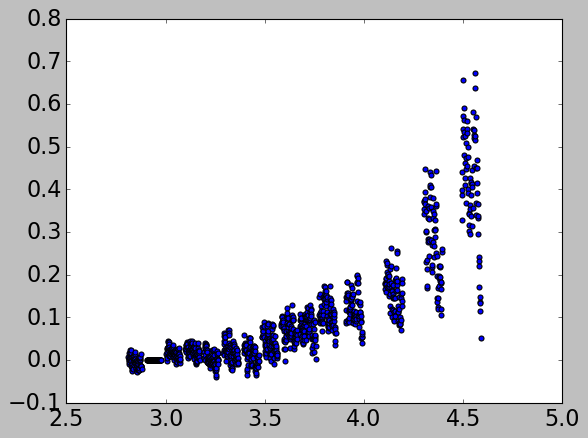

[ 1  1  1 ... 10 10 10]


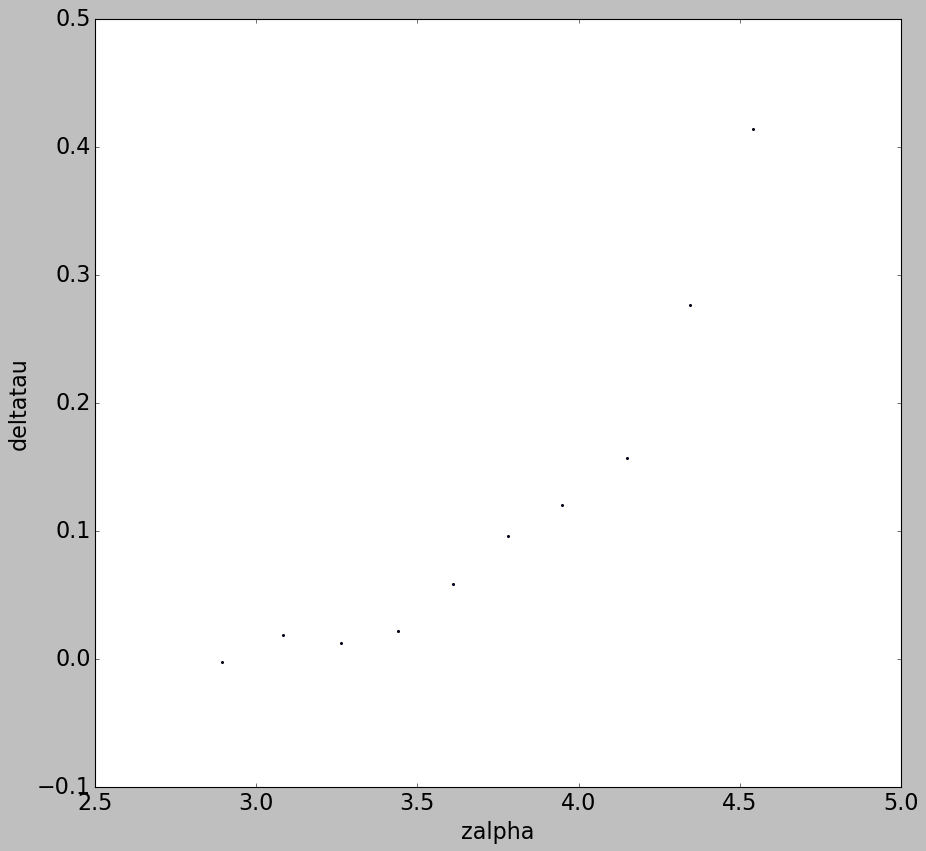

In [136]:
xbein,bint,binerrorl,binerroru,betabine = deltabeta(data_indi_wave[1:],data_indi_flux[1:],2.94,data_z[1:],10,covtest)

In [137]:
np.array(betabine)[:,9]

array([ 0.01759567,  0.02591004, -0.03467854, ...,  0.00794299,
        0.05312039,  0.06454745])

(array([2.000e+00, 0.000e+00, 4.000e+00, 7.000e+00, 1.300e+01, 4.300e+01,
        4.600e+01, 8.000e+01, 1.850e+02, 2.730e+02, 4.010e+02, 6.100e+02,
        8.370e+02, 1.030e+03, 1.117e+03, 1.222e+03, 1.099e+03, 9.370e+02,
        7.490e+02, 5.620e+02, 3.420e+02, 2.180e+02, 1.180e+02, 5.800e+01,
        2.400e+01, 1.100e+01, 8.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([-0.06621069, -0.06062787, -0.05504505, -0.04946224, -0.04387942,
        -0.0382966 , -0.03271378, -0.02713096, -0.02154814, -0.01596532,
        -0.0103825 , -0.00479968,  0.00078313,  0.00636595,  0.01194877,
         0.01753159,  0.02311441,  0.02869723,  0.03428005,  0.03986287,
         0.04544569,  0.05102851,  0.05661132,  0.06219414,  0.06777696,
         0.07335978,  0.0789426 ,  0.08452542,  0.09010824,  0.09569106,
         0.10127388]),
 <a list of 30 Patch objects>)

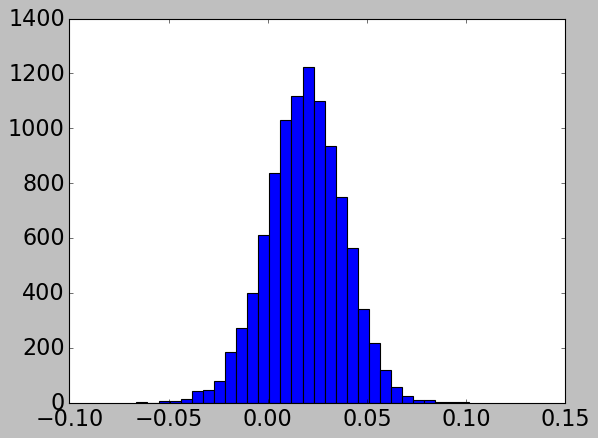

In [138]:
plt.hist(np.array(betabine)[:,9],bins=30)

In [139]:
binerrorl,binerroru

(array([[3.03954223e-04, 3.89954102e-04, 1.01992261e-04, 1.17094814e-04,
         2.75077803e-04, 4.99049119e-04, 2.24278961e-04, 5.89374232e-04,
         8.51725687e-05, 3.28485685e-04],
        [3.89954102e-04, 5.01168012e-04, 1.31024921e-04, 1.50420769e-04,
         3.53217759e-04, 6.40659349e-04, 2.87969954e-04, 7.56668098e-04,
         1.09527099e-04, 4.22422505e-04],
        [1.01992261e-04, 1.31024921e-04, 3.64021385e-05, 3.97542550e-05,
         9.27591784e-05, 1.67514925e-04, 7.56304629e-05, 1.97846467e-04,
         2.90472025e-05, 1.10363127e-04],
        [1.17094814e-04, 1.50420769e-04, 3.97542550e-05, 4.79249274e-05,
         1.06381720e-04, 1.92356159e-04, 8.68263346e-05, 2.26965067e-04,
         3.30165621e-05, 1.26457046e-04],
        [2.75077803e-04, 3.53217759e-04, 9.27591784e-05, 1.06381720e-04,
         2.52509278e-04, 4.51914584e-04, 2.03532637e-04, 5.33838017e-04,
         7.77623632e-05, 2.97246087e-04],
        [4.99049119e-04, 6.40659349e-04, 1.67514925e-04, 1.9

In [142]:
binerrf = np.sqrt(np.diagonal(binerrorl))

In [143]:
print (binerrf)

[0.01743428 0.02238678 0.00603342 0.00692278 0.01589054 0.0287606
 0.0133612  0.0343835  0.01213919 0.02688604]


In [140]:
font = {'size':20}
plt.rc('font', **font)

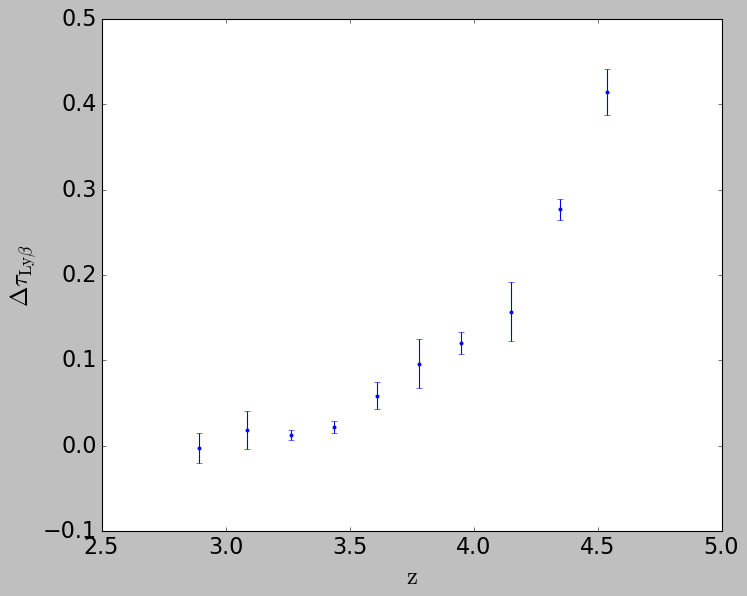

In [145]:
plt.figure(figsize=(10,8))
plt.scatter(xbein,bint,s=3)
plt.errorbar(xbein,bint,yerr = binerrf,fmt='.',capsize=3,label = 'data points')
    #plt.xlim(0,2.8)
#plt.ystick(fontsize = 15)
#plt.xstick(fontsize = 15)
plt.xlabel(r'$\rm{z}$',fontsize = 22)
plt.ylabel(r'$\rm{\Delta \tau_{Ly\beta}}$',fontsize = 22)
#plt.yscale('log')
plt.savefig('deltaubeta_0909.pdf')
plt.show()

In [ ]:
np.savetxt('bin_beta.txt', np.c_[xbein,bint], delimiter = " ", newline = '\n')